In [2]:
# automatically show plots inside the notebook
%matplotlib inline  

# reload all modules before executing code
%load_ext autoreload
%autoreload 2  

# import statements go here
import torch
import torch.nn as nn
import torch.tensor as tensor 
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import librosa
import librosa.display
import numpy as np
import importlib
import os
import pandas as pd
import matplotlib.pyplot as plt

%cd ../src
from wavenet.wavenet_model import *
import wavenet.util
from dataset import TextToSpeechDataset, WavenetLoader
from wavenet.train import Trainer

/root/env/IDP-Luminovo/tts/src/wavenet


ModuleNotFoundError: No module named 'wavenet_model'

GuitarD4.wav                   lab-initial-exploration.ipynb
LJ001-0001.wav                 lab-initial-exploration.py
Text-to-Mel.ipynb              lab-mel-wavenet.ipynb
Wavenet_archi_demo.ipynb       lab-melspectrogram.ipynb
__pycache__/                   lab-wave.ipynb
lab-initial-exploration.html   lab-wavenet-demo.ipynb


In [1]:
%cd ../../notebooks
csv_file = "data/metadata.csv"
audio_dir = 'data/wavs'
TTSDataset = TextToSpeechDataset(csv_file, audio_dir )
item = TTSDataset[1]
text = item['text']
audio=item['speech']
import IPython.display as ipd
print(text)
ipd.Audio(audio, rate=22050)

[Errno 2] No such file or directory: '../../notebooks'
/root/env/IDP-Luminovo/tts/notebooks


NameError: name 'TextToSpeechDataset' is not defined

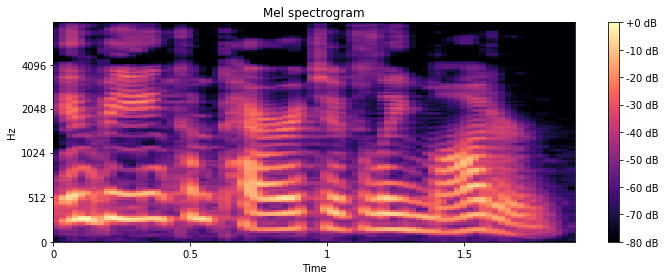

In [9]:
S = librosa.feature.melspectrogram(y=audio, sr=22050)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

### Time adjustment for mel & audio

In [10]:
print(S.shape)
pdpd=librosa.power_to_db(S, ref=np.max)
print(len(audio.shape))
print(audio.size, S.shape[0])
factor = audio.size / S.shape[0]
print(factor)
mel = np.repeat(S, factor, axis=0)
print(S.shape)
print(mel.shape)
mel_pad = audio.size - mel.shape[0]
print(mel_pad)
mel = np.pad(mel, [(0, mel_pad), (0, 0)], mode="constant", constant_values=0)
print(mel.shape)

(128, 82)
1
41885 128
327.2265625
(128, 82)
(41856, 82)
29
(41885, 82)


In [64]:
sample_size = 19
# audio input
x = util.mulaw_encode(audio, 256)[:sample_size]
x = x.float().view(1, 1, -1)
print(x.size())
# mel input
melT = np.transpose(mel[:sample_size])
melTor= torch.from_numpy(melT).float().unsqueeze(0)
print(melTor.size(-1))

torch.Size([1, 1, 19])
19


In [12]:
lc = nn.Conv1d(in_channels = 82, out_channels = 5, kernel_size = 1, bias = 0, dilation = 1)
out_lc = lc(melTor)
print(out_lc.size())

torch.Size([1, 5, 19])


In [13]:
causal = nn.Conv1d(in_channels = 1, out_channels = 7, kernel_size=1, bias=0)
out_causal = causal(x)
print(out_causal.size())

torch.Size([1, 7, 19])


In [14]:
gate = nn.Conv1d(in_channels=7, out_channels=5, kernel_size=2, dilation=4, bias=0 )
out_gate = gate(out_causal)
print(out_gate.size())

torch.Size([1, 5, 15])


In [15]:
print(out_gate.size(-1))
print(out_lc[:, :, :out_gate.size(-1)].size())

15
torch.Size([1, 5, 15])


In [16]:
gate_sum = out_gate + out_lc[:, :, :out_gate.size(-1)]
print(gate_sum.size())

torch.Size([1, 5, 15])


In [60]:
wavenet = WavenetModel(layers=2, stacks=1, dilation_channels=4, residual_channels=4, skip_channels=4, 
                                  end_channels=1, classes= 1, output_length=16, cin_channels = 82)

hiii


In [61]:
geldi = wavenet(x, melTor)

In [62]:
print(geldi.size())

torch.Size([1, 1, 16])


### TODO: Upsampling for local conditioning

In [80]:
upsample = nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size=3, stride=2, bias=1, padding=1, output_padding=1)
inp = torch.from_numpy(S).float()
c = inp.unsqueeze(0)
print(c.size())
k = upsample(Variable(c))
print(k.size())
k2 = k = upsample(k)

torch.Size([1, 128, 82])


RuntimeError: Given transposed=1, weight[1, 1, 3], so expected input[1, 128, 82] to have 1 channels, but got 128 channels instead

In [65]:
conv1d = nn.Conv1d(in_channels = 82, out_channels = 1, kernel_size=1, bias=1)
g = conv1d(k)
print(g.size(-1))

RuntimeError: Given groups=1, weight[1, 82, 1], so expected input[1, 1, 82] to have 82 channels, but got 1 channels instead